In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
import joblib
import shap


In [2]:
def logit_pvalue(model, dataset, columns):
    p = model.predict_proba(dataset[columns])
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(dataset[columns]), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    cols = columns[:]
    cols.insert(0, "intercept")
    p *= 100
    result = pd.DataFrame({"variable" : cols, "p_value" : p})
    return result
def print_log_reg_coefs(dataset, model, columns):
    fig, ax = plt.subplots(figsize = (20, 6))
    x = columns
    x_pos = np.arange(len(x))
    y = model.coef_[0]

    ax.bar(x_pos, y)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x, rotation = 45)
    plt.show()
    #print(logit_pvalue(model, dataset, columns))
def print_lin_reg_coefs(dataset, model, columns):
    fig, ax = plt.subplots(figsize = (20, 6))
    x = columns
    x_pos = np.arange(len(x))
    y = model.coef_
    ax.bar(x_pos, y)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x, rotation = 45)
    plt.show()
def metrics_class(dataset, dataset_name, target, prediction, n_buckets = 5):
    
    auc = roc_auc_score(dataset[target], dataset[prediction])
    print(f"AUC ROC {dataset_name}: {auc:.4f}")
    dataset["q"] = pd.qcut(dataset[prediction], n_buckets, labels = list(range(n_buckets)))
    dataset.groupby("q")[[target, prediction]].mean().plot(title = f"PKP for {dataset_name}")
    plt.show()
def metrics_reg(dataset, dataset_name, target, prediction):
    x = dataset[target]
    y = dataset[prediction]
    z = np.polyfit(x,y,1)
    a,b = z
    x1 = dataset["result"].min()
    y1 = (a * x1) + b
    x2 = dataset["result"].max()
    y2 = (a * x2) + b
    print(f"R2 for {dataset_name}: {r2_score(x, y):.4f}")
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_title(dataset_name)
    ax.scatter(x, y, alpha=.5, label = "prediction")
    ax.plot([x1, x2], [y1, y2], color = "red", label = "trend")
    ax.plot([x1, x2], [x1, x2], color = "green", label = "perfect")
    ax.legend()
    plt.show()

In [3]:
df = pd.read_excel('../data/seuk_04.xlsx')
names = list(df["Attack_1"].unique())

In [4]:
df['month'] = df['Date'].dt.month


In [5]:
df = df.drop('Date', axis = 1)

In [6]:
pd.unique(df[['Attack_1', 'Defence_1', 'Attack_2', 'Defence_2']].values.ravel('K'))


array(['Szymon', 'Dawid', 'Krzysiu', 'Wojtek', 'Kuba', 'Eryk'],
      dtype=object)

In [7]:
df_dumm = pd.get_dummies(df, columns = ["Attack_1","Defence_1", "Attack_2", "Defence_2"])

In [8]:
dumm_columns = list(set(df_dumm.columns) - set(df.columns))
dumm_columns = sorted(dumm_columns, key=lambda x: x[x.rfind("_") + 1:] + x[:x.rfind("_")])


In [9]:
df_dumm["win_team_1"] = df_dumm["Win"].apply(lambda x: 1 if x == 1 else 0)
df_dumm['month'] = df['month']


In [10]:
train_size = int(df_dumm.shape[0] * 0.8)

train = df_dumm.iloc[:train_size]
test = df_dumm.iloc[train_size:]

train_cols = dumm_columns + ['month']

In [11]:
model = LogisticRegression(penalty = None, fit_intercept = True)

AUC ROC train: 0.8401


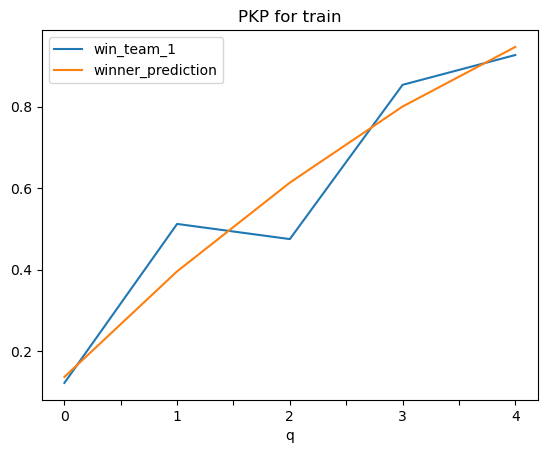

AUC ROC test: 0.7225


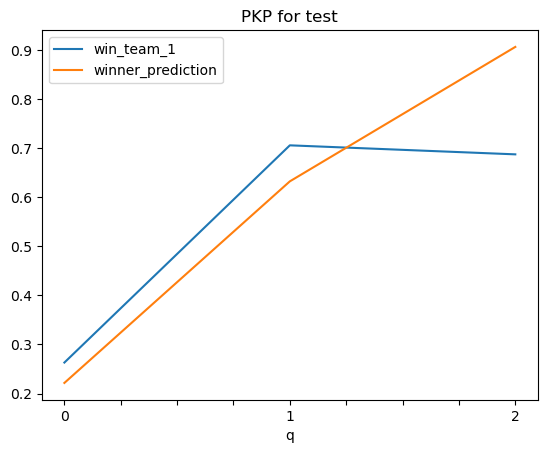

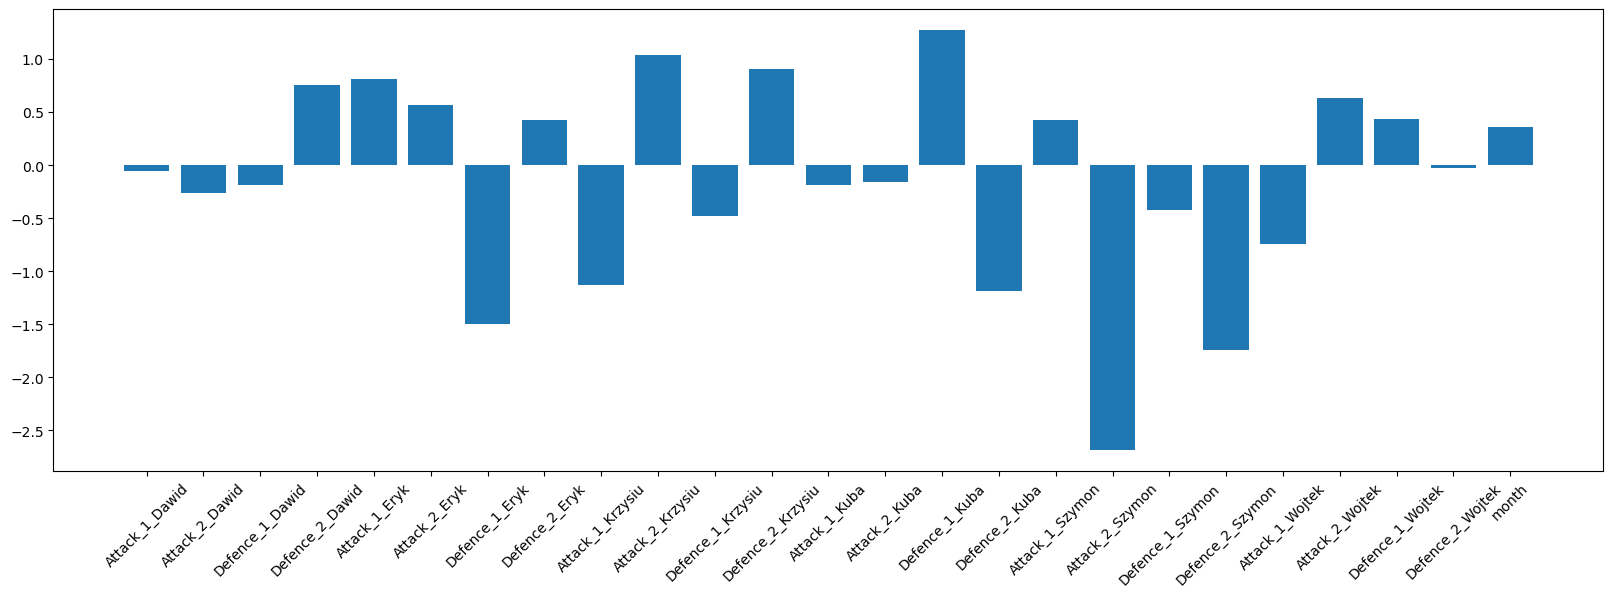

In [12]:
model.fit(train[train_cols], train["win_team_1"])
test["winner_prediction"] = model.predict_proba(test[train_cols])[:, 1]
train["winner_prediction"] = model.predict_proba(train[train_cols])[:, 1]
metrics_class(train, "train", "win_team_1", "winner_prediction")
metrics_class(test, "test", "win_team_1", "winner_prediction", 3)
print_log_reg_coefs(train, model, train_cols)


In [ ]:
for i in 

In [52]:
joblib.dump(model,'models/log_reg.plk' )

['models/log_reg.plk']

In [33]:
# ohe = OneHotEncoder()
# X_one_hot = ohe.fit_transform(X)
# columns_names = ohe.get_feature_names_out(['Attack_1', 'Defence_1', 'Attack_2', 'Defence_2'])
# one_hot_encoded_frame = pd.DataFrame.sparse.from_spmatrix(X_one_hot, columns=columns_names)


NameError: name 'OneHotEncoder' is not defined